# California Housing Price Model

### Big picture

Use CA census data to build a model of housing prices in the state. The data includes metrics such as the population, median income, and median housing price for each 'block group'. Block groups are the smallest geographical unit that the US Census Bureau publishes sample data - referred to as districts in this script. The primary goal of this model is to predict median housing price in any district.

*What is the business objective?* Output from this model will be fed into another ML system, along with additional signals, which will determine whether an area is worth investment.



In [1]:
from packaging import version
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

### Get the data

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

C:\Users\Paul.Carvalho\AppData\Local\Temp\ipykernel_18728\2839428726.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="datasets")


In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

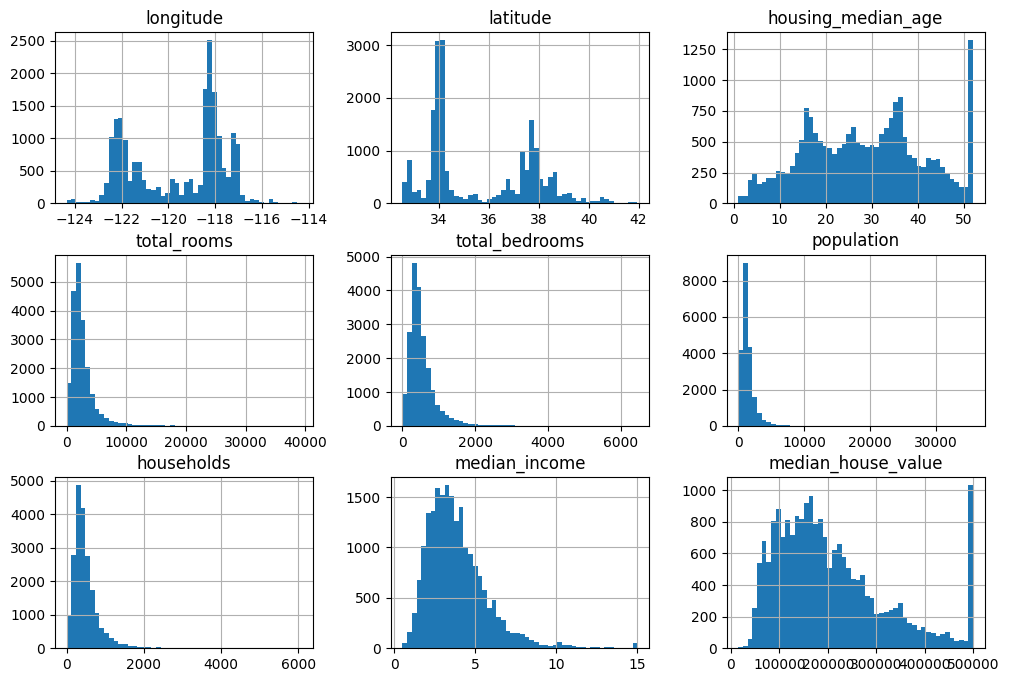

In [7]:
housing.hist(bins=50, figsize=(12,8))
plt.show()

From these histograms we see:
1. Median income is not in USD. Data are scaled and restricted to 0.5 and 15. These values represent tens of thousands of dollars.
2. Housing median age and value were also capped.
3. The attributes have very different scales - suggest feature scaling is warranted.
4. Many of the histograms are skewed right.

### Create a test set

In [8]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### Exlpore data

In [9]:
housing = train_set.copy()

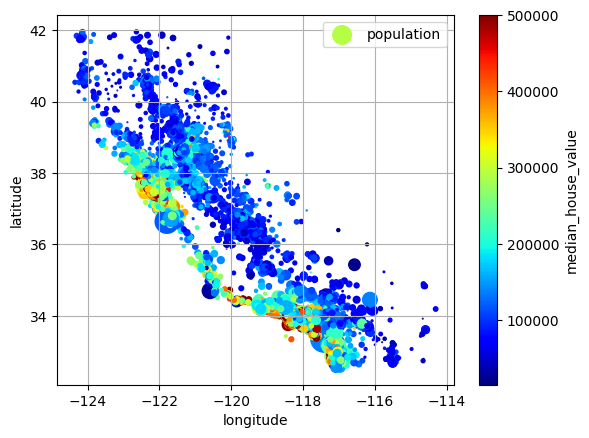

In [10]:
housing.plot(kind="scatter", x='longitude', y='latitude', grid=True,
             s=housing['population']/100, label="population",
             c='median_house_value', cmap='jet', colorbar=True,
             legend=True, sharex=False)
plt.show()

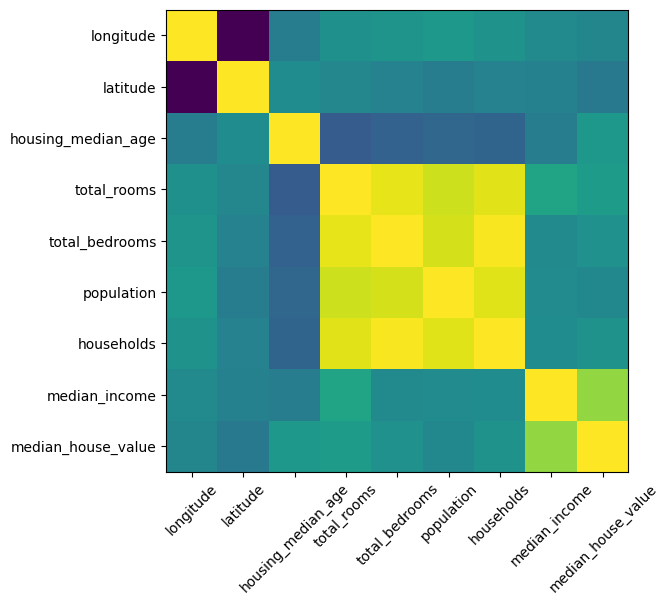

In [11]:
corr_mat = housing.corr(numeric_only=True)
plt.figure(figsize=(6,6))
plt.imshow(corr_mat, cmap='viridis'),
plt.xticks(ticks=range(corr_mat.shape[0]),
           labels=corr_mat.columns,
           rotation=45)
plt.yticks(ticks=range(corr_mat.shape[0]),
           labels=corr_mat.columns)
plt.show()

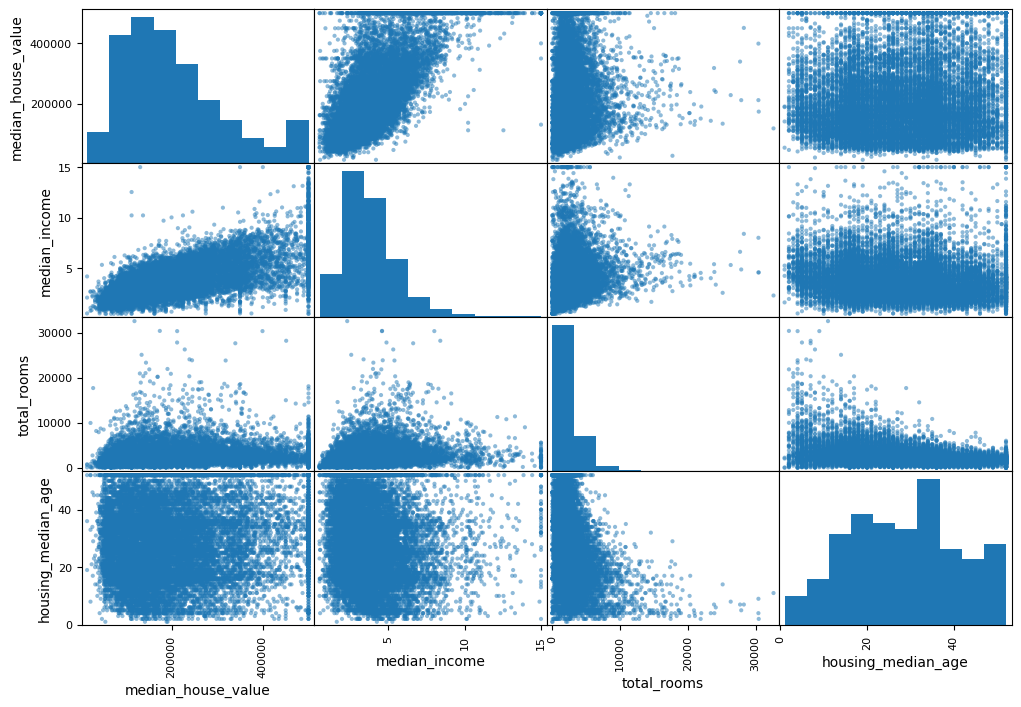

In [12]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

### Feature engineering

In [13]:
housing['rooms_per_house'] = housing['total_rooms']/housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms']/housing['total_rooms']
housing['people_per_house'] = housing['population']/housing['households']

In [14]:
corr_mat = housing.corr(numeric_only=True)
corr_mat['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687013
rooms_per_house       0.146940
total_rooms           0.134060
housing_median_age    0.104714
households            0.065798
total_bedrooms        0.049993
people_per_house     -0.021577
population           -0.025820
longitude            -0.043603
latitude             -0.146324
bedrooms_ratio       -0.254817
Name: median_house_value, dtype: float64

### Prepare data for ML

In [15]:
housing = train_set.drop('median_house_value', axis=1)
housing_labels = train_set['median_house_value'].copy()

In [16]:
# Impute missing data

imputer = SimpleImputer(strategy='median')
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [17]:
imputer.statistics_

array([-118.49  ,   34.25  ,   29.    , 2129.    ,  437.    , 1169.    ,
        411.    ,    3.5246])

In [18]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, 
                          columns=housing_num.columns,
                          index=housing_num.index)

In [19]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
14196,NEAR OCEAN
8267,NEAR OCEAN
17445,NEAR BAY
14265,<1H OCEAN
2271,INLAND
17848,NEAR BAY
6252,INLAND
9389,<1H OCEAN
6113,INLAND
6061,<1H OCEAN


In [20]:
one_hot_enc = OneHotEncoder()
housing_cat_1hot = one_hot_enc.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [21]:
one_hot_enc.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#### Feature scaling and transformation

In [22]:
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

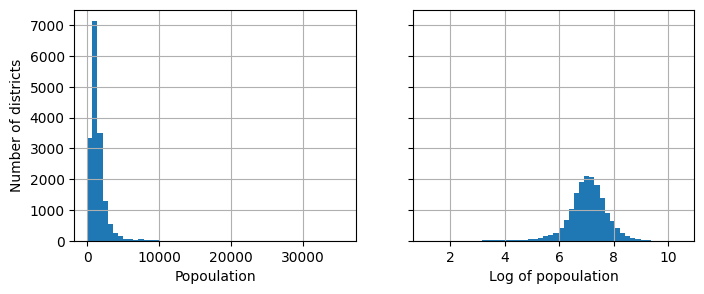

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(8,3), sharey=True)
housing['population'].hist(ax=axs[0], bins=50)
housing['population'].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Popoulation")
axs[0].set_ylabel("Number of districts")
axs[1].set_xlabel("Log of popoulation")

plt.show()

In [24]:
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

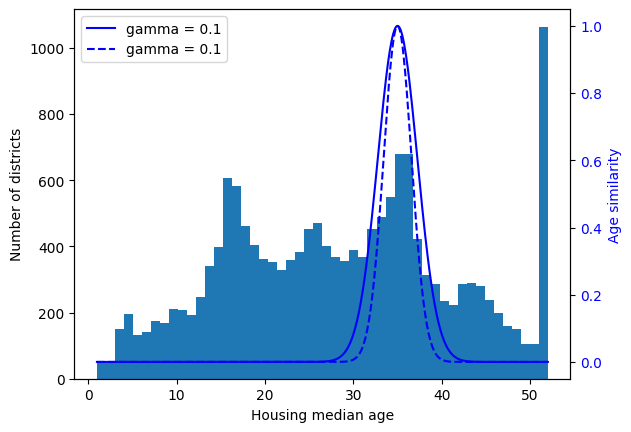

In [25]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1,1)
gamma1 = 0.1
gamma2 = 0.2
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()
ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()
ax2.plot(ages, rbf1, color='blue', label="gamma = 0.1")
ax2.plot(ages, rbf2, color='blue', label="gamma = 0.1", linestyle="--")
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylabel("Age similarity", color='blue')
plt.legend(loc="upper left")
plt.show()



In [26]:
# Simple linear model to test inverse_transform on target value
from sklearn.linear_model import LinearRegression

target_scalar = StandardScaler()
scaled_labels = target_scalar.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]

scaled_predictions = model.predict(some_new_data)
predictions = target_scalar.inverse_transform(scaled_predictions)

predictions

array([[236054.10114638],
       [239237.69758773],
       [198830.83002753],
       [259972.41986486],
       [107097.77256737]])

In [27]:
# Now take a look at TransformedTargetRegressor
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
model.predict(some_new_data)

array([236054.10114638, 239237.69758773, 198830.83002753, 259972.41986486,
       107097.77256737])

In [28]:
# Create a log transformer
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [29]:
# Try creating a custom transformer similar to StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean

    def fit(self, X, y=None):
        X = check_array() # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]
        return self
    
    def transform(self, X):
        check_is_fitted(self) # looks for learned attributes (within trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_


In [30]:
# Cluster similarity transformer
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters,
                              n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


In [31]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

In [32]:
similarities[:3].round(2)

array([[0.22, 0.  , 0.  , 0.  , 0.  , 0.05, 0.93, 0.  , 0.  , 0.  ],
       [0.15, 0.  , 0.  , 0.  , 0.  , 0.03, 0.93, 0.  , 0.  , 0.  ],
       [0.  , 0.72, 0.  , 0.  , 0.  , 0.  , 0.  , 0.97, 0.1 , 0.21]])

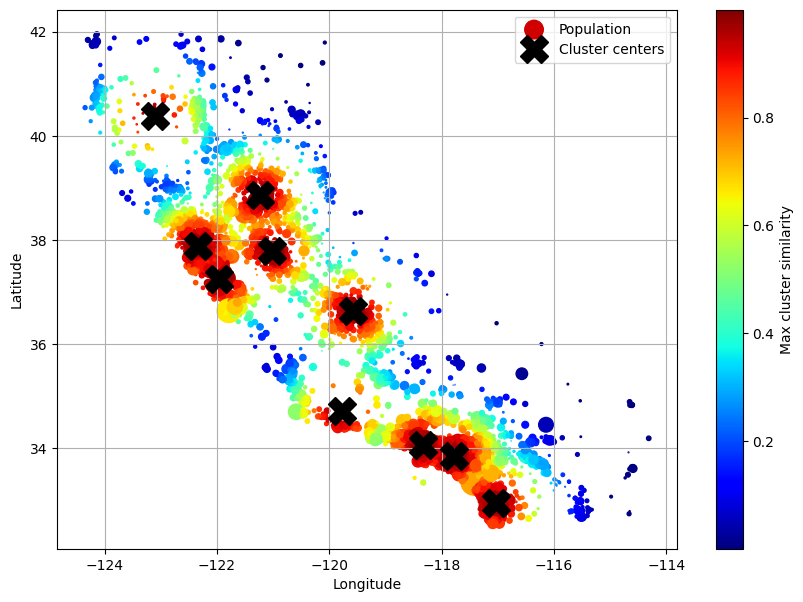

In [33]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

#### Transformation pipelines

In [34]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [35]:
from sklearn import set_config
set_config(display='diagram')
num_pipeline

,steps,"[('impute', ...), ('standardize', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [36]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[ 1.17, -1.35,  0.43,  1.57,  1.38,  1.08,  1.51,  0.38],
       [ 1.27, -1.38, -1.47, -0.81, -0.9 , -0.64, -0.88,  0.42]])

In [37]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared,
    columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index
)

In [38]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

In [39]:
housing_prepared = preprocessing.fit_transform(housing)
df_housing_prepared = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index
)


In [40]:
# Put all of the above together for a comprehensive pipeline
from sklearn.compose import ColumnTransformer

def column_ratio(X):
    return X[:,[0]]/X[:,[1]]

def ratio_name(function_transformer, feature_names_in):
    return["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10,
                                  gamma=1.,
                                  random_state=42)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ['total_bedrooms', 'total_rooms']),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ['total_bedrooms', 
                           'total_rooms', 
                           'population',
                           'households',
                           'median_income']),
    ("geo", cluster_simil, ['latitude', 'longitude']),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object))
],
remainder=default_num_pipeline)

In [41]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [42]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

### Select and train model

#### Train and eval on training set

In [43]:
# Start with a simple linear regression model
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

,steps,"[('columntransformer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [44]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)

array([263600., 199900., 275900., 281800.,  51900.])

In [45]:
housing_labels.iloc[:5].values

array([291000., 156100., 353900., 241200.,  53800.])

In [46]:
from sklearn.metrics import root_mean_squared_error

lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

68743.64454430732

The model is underfitting the training data with a prediction error of $68,743

In [47]:
# Try a decision tree regressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

,steps,"[('columntransformer', ...), ('decisiontreeregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [48]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

The decision tree regression is likely overfitting the data.

#### Cross-validation

In [49]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg,
                              housing,
                              housing_labels,
                              scoring="neg_root_mean_squared_error",
                              cv=10)

In [50]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     65885.969159
std       1978.523862
min      62467.704755
25%      64356.035929
50%      66408.426307
75%      67617.232424
max      67706.608347
dtype: float64

We confirmed that this is an overfitting problem because the training error is low (actually 0) but the validation error is high.

In [51]:
# Random forest model
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg,
                                housing,
                                housing_labels,
                                scoring = "neg_root_mean_squared_error", cv=10)

In [52]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     46629.768181
std       1030.208068
min      44911.114228
25%      46136.371517
50%      46499.156908
75%      47256.931024
max      48149.214837
dtype: float64

In [ ]:
forest_reg.fit(housing, housing_labels)

,steps,"[('columntransformer', ...), ('randomforestregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [57]:
housing_predictions = forest_reg.predict(housing)
forest_rmse = root_mean_squared_error(housing_labels, housing_predictions)
forest_rmse

17537.474966235408

Random forest is much better, but the RMSE on the training set is still lower than the mean RMSE from the cross-validation which suggests that Random Forest Regression is still overfitting. Future potential ML algorithms wcould be SVMs with different kernels and nueral networks.

#### Fine-tune model

In [68]:
# Grid search
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

In [69]:
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15, 20],
     'random_forest__max_features': [6, 8, 10]},
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')

grid_search.fit(housing, housing_labels)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'preprocessing__geo__n_clusters': [5, 8, ...], 'random_forest__max_features': [4, 6, ...]}, {'preprocessing__geo__n_clusters': [10, 15, ...], 'random_forest__max_features': [6, 8, ...]}]"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"


In [74]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 20, 'random_forest__max_features': 6}

In [73]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
15,5.278754,0.374970,0.120044,0.008826,20,6,"{'preprocessing__geo__n_clusters': 20, 'random...",-42325.231074,-43082.597776,-43343.608248,-42917.145699,431.897989,1
16,6.314570,0.106621,0.110456,0.005761,20,8,"{'preprocessing__geo__n_clusters': 20, 'random...",-42994.558702,-43347.908868,-43670.023964,-43337.497178,275.855799,2
12,5.022852,0.014797,0.107690,0.004588,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-43014.817158,-44023.136819,-43879.701355,-43639.218444,445.384596,3
17,7.694448,0.078369,0.105825,0.002908,20,10,"{'preprocessing__geo__n_clusters': 20, 'random...",-43121.701033,-43812.368396,-44068.164003,-43667.411144,399.756169,4
13,6.231166,0.194312,0.113082,0.004020,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-43753.887202,-44041.945826,-44123.632218,-43973.155082,158.591654,5


In [ ]:
# Randomized search
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV


In [76]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_distribs,
    n_iter=10,
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=42)

rnd_search.fit(housing, housing_labels)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'preprocessing__geo__n_clusters': <scipy.stats....00210D582F620>, 'random_forest__max_features': <scipy.stats....00210D5E67D90>}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [82]:
final_model = rnd_search.best_estimator_
feature_importances = final_model['random_forest'].feature_importances_
feature_importances.round(2)

array([0.07, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.18, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.  , 0.01, 0.02, 0.01, 0.01, 0.01, 0.02, 0.  , 0.01,
       0.02, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.03, 0.01, 0.01, 0.04, 0.01, 0.02, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [83]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(np.float64(0.18230279007299027), 'log__median_income'),
 (np.float64(0.06949515325320092), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.06942528034566388), 'bedrooms__ratio'),
 (np.float64(0.05755006233217791), 'rooms_per_house__ratio'),
 (np.float64(0.04758221887992159), 'people_per_house__ratio'),
 (np.float64(0.044511859246479754), 'geo__Cluster 32 similarity'),
 (np.float64(0.026572253192884074), 'geo__Cluster 29 similarity'),
 (np.float64(0.02310935558213975), 'geo__Cluster 11 similarity'),
 (np.float64(0.02265448223163772), 'geo__Cluster 17 similarity'),
 (np.float64(0.018058101954159654), 'geo__Cluster 7 similarity'),
 (np.float64(0.018047466903567958), 'geo__Cluster 14 similarity'),
 (np.float64(0.01735898187107166), 'geo__Cluster 34 similarity'),
 (np.float64(0.015037617517181108), 'geo__Cluster 40 similarity'),
 (np.float64(0.014845664740180304), 'geo__Cluster 4 similarity'),
 (np.float64(0.013889852422028897), 'geo__Cluster 36 similarity'),
 (np.float64(0.013831102919822

### Evaluate system on test set

In [86]:
test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-122.38,40.67,10.0,2281.0,444.0,1274.0,438.0,2.2120,65600.0,INLAND
3024,-118.37,33.83,35.0,1207.0,207.0,601.0,213.0,4.7308,353400.0,<1H OCEAN
15663,-117.24,32.72,39.0,3089.0,431.0,1175.0,432.0,7.5925,466700.0,NEAR OCEAN
20484,-118.44,34.05,18.0,4780.0,1192.0,1886.0,1036.0,4.4674,500001.0,<1H OCEAN
9814,-118.44,34.18,33.0,2127.0,414.0,1056.0,391.0,4.3750,286100.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
15362,-121.92,40.52,13.0,4581.0,881.0,1799.0,734.0,2.2993,99500.0,INLAND
16623,-122.08,37.68,26.0,2607.0,682.0,1401.0,607.0,2.6563,184100.0,NEAR BAY
18086,-119.00,35.39,42.0,2839.0,516.0,1203.0,487.0,3.7708,79400.0,INLAND
2144,-117.92,33.63,39.0,1469.0,226.0,553.0,225.0,7.8496,490800.0,<1H OCEAN


In [90]:
X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)
final_rmse

42121.65737109745

Computer 95% confidence intervals

In [93]:
from scipy import stats

def rmse(squared_errors):
    return np.sqrt(np.mean(squared_errors))

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
boot_result = stats.bootstrap([squared_errors], rmse,
                              confidence_level=confidence, random_state=42)
rmse.lower, rmse.upper = boot_result.confidence_interval

rmse.lower, rmse.upper

(np.float64(40050.74191136242), np.float64(44558.93093791382))

### Launch, monitor, and maintain system

In [95]:
import joblib

joblib.dump(final_model, "ca_housing_price_model.pkl")

['ca_housing_price_model.pkl']

Here's an example of running the model in production.

In [97]:
import joblib

# extra code – excluded for conciseness
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("ca_housing_price_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

In [98]:
predictions

array([271852., 151762., 308196., 242896.,  67067.])